# Collaborative Superpixelwise Autoencoderの実装

**[書誌情報]**
- タイトル
    - A Collaborative Superpixelwise Autoencoder for Unsupervised Dimension Deduction in Hyperspectral Images
- 著者
    - Chao Yao, Lingfeng Zheng, Longchao Feng, Fan Yang, Zehua Guo, Miao Ma
- 出版
    - Received: 21 July 2023 / Revised: 23 August 2023 / Accepted: 24 August 2023 / Published: 27 August 2023
- DOI: https://doi.org/10.3390/rs15174211

**[Abstract]**
- [論文紹介スライド](https://drive.google.com/file/d/1nj9pMiVVg5Q-G_UObhXD0QsFzxGZKAlV/view?usp=sharing)
- Superpixel-based approaches
    - サンプルをグループに分け、小さなグループにDR(Dimension Reduction)技術を適応
    - 良い点
        - HSIデータの**スペクトル空間情報**を柔軟に扱うことができる
    - 課題
        - 同じクラスからのサンプルが異なるSuperpixelに存在する可能性があるという事実を無視することにより、クラス内格差を増加させ、結果的に性能を低下させることがわかった
- Collaborative superpixelwise Auto-Encoder (**ColAE**)
    - クラス内格差を低減するため、たとえ異なるsuperpixelに位置するとしても、同じクラスからのサンプルが符号空間（code空間）において同様の表現を持つように制限する**多様体損失**を導入する

**[実装の概要]**
- HSIデータの読み込み
- ColAEの実装
1. Superpixel segmentation with ERS

 1.1. PCA

 1.2. ERS -> SLIC

2. Collaborative AEs

 2.1. LLE

 2.2. パラメータを $\Theta^{(0)}$ に初期化

 2.3. AEの損失関数と多様体損失関数の２つの損失関数を計算し、即時のoptimizerを用いて $g^(t)$ の勾配を計算し、$\Theta^{(t+1)} = \Theta^(t) + \alpha g^(t) $ でパラメータを更新

 2.4. $\Theta^(t)$ によって符号空間を計算し、 $Y \in \mathbb{R}^{L \times W \times H}$ を再形成する



#### Pyhton version -----

In [1]:
# !sudo apt install python3.7
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
# !sudo update-alternatives --config python3


#### ----------

## HSIデータの読み込み

[HISUI](https://www.jspacesystems.or.jp/project/observation/hisui/)のデータを[Tellus](https://www.tellusxdp.com/ja/catalog/data/hisui.html)からダウンロードして使用

[使用したデータのダウンロード先リンク](https://www.tellusxdp.com/traveler/viewer/?q=%257B%2522center%2522%253A%255B139.67269389063912%252C35.62839714641322%255D%252C%2522zoom%2522%253A10.828120584428342%252C%2522searchMapState%2522%253A%257B%2522nameState%2522%253A%257B%2522name%2522%253A%2522%2522%252C%2522mode%2522%253Anull%257D%252C%2522observationDateRange%2522%253A%257B%2522start%2522%253Anull%252C%2522end%2522%253Anull%252C%2522active%2522%253Afalse%257D%252C%2522publishedDateRange%2522%253A%257B%2522start%2522%253Anull%252C%2522end%2522%253Anull%252C%2522active%2522%253Afalse%257D%252C%2522aoiState%2522%253A%257B%2522geometry%2522%253A%257B%2522type%2522%253A%2522Polygon%2522%252C%2522coordinates%2522%253A%255B%255B%255B127.16499790831209%252C5.308236535699957%255D%252C%255B168.8696729544158%252C5.308236535699957%255D%252C%255B168.8696729544158%252C44.85495239409777%255D%252C%255B127.16499790831209%252C44.85495239409777%255D%252C%255B127.16499790831209%252C5.308236535699957%255D%255D%255D%257D%252C%2522mode%2522%253A%2522intersect%2522%257D%252C%2522condition%2522%253A%257B%2522dataset%2522%253A%255B%252268f7270f-414f-4587-aaee-01389678d425%2522%252C%2522f1979af1-7585-4251-8225-965d61b4373a%2522%255D%252C%2522properties%2522%253A%257B%257D%252C%2522datasetsType%2522%253A%2522public%2522%257D%252C%2522order%2522%253A%257B%2522field%2522%253A%2522properties.end_datetime%2522%252C%2522direction%2522%253A%2522desc%2522%257D%252C%2522onlyDownloadableFile%2522%253A%257B%2522active%2522%253Afalse%252C%2522value%2522%253Afalse%257D%252C%2522scene%2522%253A%2522detail%2522%252C%2522consoleOpened%2522%253Atrue%252C%2522selectedData%2522%253A%257B%2522dataset%2522%253A%252268f7270f-414f-4587-aaee-01389678d425%2522%252C%2522data%2522%253A%2522bcbda156-8ee9-49db-947b-782f221496b0%2522%257D%257D%257D) (ログインが必要)

### データの読み込み

device: cuda:0
dtype: float32, shape: (83, 960, 960), min: 0.0, max: 1.0
aft mean:-7.91792231780164e-08, std:0.9999991059303284
dtype: float32, shape: (83, 960, 960), min: -6.347601413726807, max: 7.268163204193115


<function matplotlib.pyplot.show(close=None, block=None)>

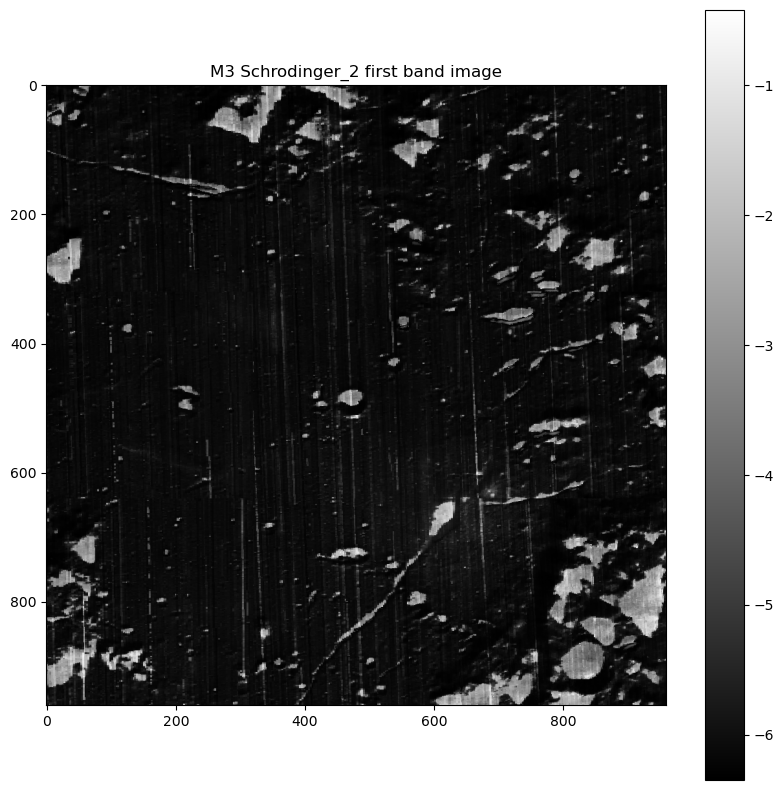

In [2]:
import numpy as np
import os
import glob
import cv2
from osgeo import gdal
import matplotlib.pyplot as plt
import torch
import time

#from livelossplot import PlotLosses

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

# ファイルの読み込み
data_name = 'Schrodinger_2'
#file_path = '../Dataset/M3/'+data_name+'/data/'+data_name+'/'+data_name+'_map.tif'
#file_path = '../Dataset/M3/'+data_name+'/data/'+data_name+'/'+data_name+'_norm_750_rmoutliner_11.tif'
file_path = '../Dataset/M3/'+data_name+'/data/'+data_name+'/'+data_name+'_norm_750_hullquotient.tif'

imgs_ = gdal.Open(file_path)
imgs = np.array(imgs_.ReadAsArray(), np.float32) # [0~1]にスケーリング正規化かつfloat64->float32へ変換
#print(f'dtype: {imgs.dtype}, shape: {imgs.shape}, min: {np.min(imgs)}, max: {np.max(imgs)}')
#imgs = imgs[3:] # band 1, 2は真っ黒なため削除
#imgs = imgs[1:]
#print(f'dtype: {imgs.dtype}, shape: {imgs.shape}, min: {np.min(imgs)}, max: {np.max(imgs)}')
#imgs = imgs[:-1]
band_size = imgs.shape[0] # band number
print(f'dtype: {imgs.dtype}, shape: {imgs.shape}, min: {np.min(imgs)}, max: {np.max(imgs)}')

import scipy.stats
imgs = scipy.stats.zscore(imgs) # 平均0, 分散1に標準化
print(f'aft mean:{np.mean(imgs)}, std:{np.std(imgs)}')
print(f'dtype: {imgs.dtype}, shape: {imgs.shape}, min: {np.min(imgs)}, max: {np.max(imgs)}')

# plot
plt.figure(figsize=(10,10))
plt.title(f"M3 {data_name} first band image")
plt.imshow(imgs[0], cmap='gray')
plt.colorbar()
plt.show


## 1. Superpixel segmentation with ERS

### 1.1 Principal Componet Analysis (PCA)

In [3]:
# 画像をバンドごとに平坦化
# 波長 82 band
imgs_pca_input = imgs.reshape(band_size, -1).transpose()

print(imgs_pca_input.shape)


(921600, 83)


In [4]:
# 画像180x1794x1891（band, h, w）にPCAを適用
from sklearn.decomposition import PCA

# chanel: 82　->　3（主成分）
pca = PCA(3)
imgs_pca_output = pca.fit_transform(imgs_pca_input)

imgs_pca_output.shape


(921600, 3)

#### 表示

In [5]:
# plt.style.use('seaborn-whitegrid')
# fig = plt.figure(figsize = (10,6))
# ax = fig.add_subplot(1,1,1,projection='3d')
# ax.set_xlabel('PC_1')
# ax.set_ylabel('PC_2')
# ax.set_zlabel('PC_3')
# c_map = plt.cm.get_cmap('jet', 10)
# mappable = ax.scatter(imgs_pca_output[:, 0], imgs_pca_output[:, 1], imgs_pca_output[:, 2], s = 15, cmap = c_map, marker='.')
# fig.colorbar(mappable, ax=ax)
# plt.show()


### 1.2 Entropy Rate Superpixel Segmentation (ERS)

ERSを用いて、Superpixel Segmentaionを作成

GitHub: https://github.com/mingyuliutw/EntropyRateSuperpixel

[ERSを採用する理由]
- HSI分類タスクにおいての有望な性能が示されている

 1. Jiang+ (2018): [A superpixelwise PCA approach for unsupervised feature extraction of hyperspectral imagery](https://doi.org/10.1109/TGRS.2018.2828029)

 → 前処理プロセスとして用いるため計算量を少なくする必要がある。（具体的に、他の手法と比較してどれだけ計算量が少なく、かつどれだけの性能なのか調べる必要がある。）
 2. Zhang+ (2022): [Spectral-spatial and superpixelwise PCA for unspervised feature extraction of hyperspectral imaagery](https://doi.org/10.1109/TGRS.2021.3057701)


- 適用的領域生成とテクスチャ保存における固有の能力がある

\\
また今後として、マルチスケールスーパーピクセルに拡張でき、精度向上が期待できる。

In [6]:
# # Githubからclone
# %cd /content/drive/MyDrive/Intern/Intern_S2023/ColAE
# !pwd
# !ls
# #!git clone https://github.com/mingyuliutw/EntropyRateSuperpixel.git
# %cd '/content/drive/MyDrive/Intern/Intern_S2023/ColAE/EntropyRateSuperpixel/'


In [7]:
# # PCAによって180から3chanelにした擬似カラー画像
# imgs_ers_input = imgs_pca_output.reshape(imgs.shape[1], imgs.shape[2], -1)
# print(imgs_ers_input.shape)
# plt.imshow(imgs_ers_input)

# # Matlab に読み込むように保存
# imgs_ers_input_path = '/content/drive/MyDrive/Intern/Intern_S2023/ColAE/imgs_ers_input.jpg'

# # BGR to RGB
# imgs_ers_input_rgb = imgs_ers_input[:, :, [2, 1, 0]]
# cv2.imwrite(imgs_ers_input_path, imgs_ers_input_rgb, [cv2.IMWRITE_JPEG_QUALITY, 100])


In [8]:
# imgs_ers_input_path = '/content/drive/MyDrive/Intern/Intern_S2023/ColAE/imgs_ers_input.jpg'
# tmp = cv2.imread(imgs_ers_input_path)
# # BGR to RGB
# tmp_rgb = tmp[:, :, [2, 1, 0]]
# plt.imshow(tmp_rgb)


#### ERSのGitHubコードがMATLABで使えそうなので、MATLABで作成したSuperpixel Segementaion by using ERSを読み込む

In [9]:
# !ls


Python3のバージョンによる以下のようなエラーが発生するための解決する方法の提供先

ModuleNotFoundError: No module named 'erspy'

GitHub: https://github.com/aniku777tw/ERS-EntropyRateSuperpixel

In [10]:
# %cd /content/drive/MyDrive/Intern/Intern_S2023/ColAE
# !pwd
# !ls
# #!git clone https://github.com/aniku777tw/ERS-EntropyRateSuperpixel.git
# %cd '/content/drive/MyDrive/Intern/Intern_S2023/ColAE/ERS-EntropyRateSuperpixel'


In [11]:
# !python --version


In [12]:
# %cd ERS_Python
# !ls


In [13]:
# !python compile_cpp.py build


In [14]:
# %cd ..
# !ls


In [15]:
# !python demoERS.py


In [16]:
# from ERSModule import *
# import cv2
# import numpy as np

# def colormap(input,colors):
# 	height = input.shape[0]
# 	width  = input.shape[1]
# 	output = np.zeros([height,width,3],np.uint8)
# 	for y in range(0,height):
# 		for x in range(0,width):
# 			id = int(input[y,x])
# 			for k in range(0,3):
# 				output[y,x,k] = colors[id,k]
# 	return output

# nC = 100

# # BGR to RGB
# imgs_ers_input_rgb = imgs_ers_input[:, :, [2, 1, 0]]
# #grayImg = cv2.cvtColor(imgs_ers_input_rgb,cv2.COLOR_BGR2GRAY)
# # print grayImg.shape
# seg = ERS()
# segmentation = seg.ComputeSegmentation(np.uint8(imgs_ers_input_rgb), nC)[0]

# colors = np.uint8(np.random.rand(nC,3)*255)
# output = colormap(segmentation,colors)
# cv2.imshow("img", imgs_ers_input_rgb)
# cv2.imshow("segmentation",output)
# cv2.waitKey()
# cv2.destroyAllWindows()


### 1.2 Simple Linear Iterative Clustering (SLIC) （ERSの代わり）

SLICを用いて、Superpixel Segmentaionを実施

Stutz+ (2016)が推奨しているSuperpixel Segmentaion手法の１つ

scikit-imageやOpenCVで実装が公開されている

[利用例]
- アノテーションの効率化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(960, 960, 3)


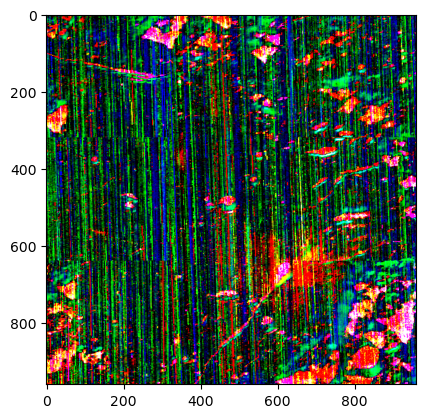

In [17]:
# PCAによって180から3chanelにした擬似カラー画像
imgs_slic_input = imgs_pca_output.reshape(imgs.shape[1], imgs.shape[2], -1)

# BGR to RGB
#imgs_slic_input_rgb = imgs_slic_input[:, :, [2, 1, 0]]
imgs_slic_input_rgb = imgs_slic_input

print(imgs_slic_input_rgb.shape)
plt.imshow(imgs_slic_input_rgb)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


J (nSeg) = 410


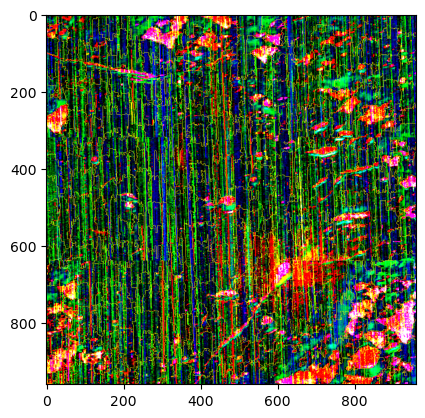

In [18]:
# Superpixel Segmentaion のパラメータ
height, width, channels = imgs_slic_input.shape[:3]
region_size = 35
ruler = 5
min_element_size = 30
num_iterations = 20  # 反復回数

# 64ビットから32ビットへの変換
imgs_slic_input_32f = np.float32(imgs_slic_input_rgb)
imgs_slic_input_hsv = cv2.cvtColor(imgs_slic_input_32f, cv2.COLOR_BGR2HSV)

slic = cv2.ximgproc.createSuperpixelSLIC(imgs_slic_input_hsv, cv2.ximgproc.SLIC, region_size, float(ruler))

# 画像のスーパーピクセルセグメンテーションを計算
# 入力画像は,HSVまたはL*a*b*
slic.iterate(num_iterations)
slic.enforceLabelConnectivity(min_element_size)

labels = slic.getLabels()

# スーパーピクセルセグメンテーションの境界を取得
contour_mask = slic.getLabelContourMask(False)
imgs_slic_output = imgs_slic_input_rgb.copy()
imgs_slic_output[0 < contour_mask] = (255, 255, 0)

# セグメンテーション数の取得
# ColAE論文中の J (nseg) にあたる（Jが100前後の時が性能が良い）
# 論文中のDataset（Indian: 145x145, UoPavia: 610x340, Salinas: 512x217）
## と比較して今回のデータは　1640x998　と3倍ほど大きいので J も少し大きい値でもいいか？
J = slic.getNumberOfSuperpixels()

lbavgimg = np.zeros((height, width, channels), dtype=np.uint8)
meanimg = np.zeros((J, channels+1), dtype=np.float32)

# 画像表示
print(f'J (nSeg) = {J}')
plt.imshow(imgs_slic_output)


## 2. Collaborative AEs

### セグメンテーションごとにベクトルを作成

$$
X = ({X^1, X^2, ..., X^J})
$$

, where
$$
X^i = ({X_1}^i, {X_2}^i, ..., {X_{N_i}}^i)
$$
$$X^i \in \mathbb{R}^{B \times {N_i}}$$

$N_i$ : i番目のSuperpixelのサンプル数


In [19]:
print(f'size: {labels.shape}')
print(f'画像pixelごとのseglabel: {labels}')


size: (960, 960)
画像pixelごとのseglabel: [[  0   0   0 ...  16  16  16]
 [  0   0   0 ...  16  16  16]
 [  0   0   0 ...  16  16  16]
 ...
 [385 385 385 ... 399 399 399]
 [385 385 385 ... 399 399 399]
 [405 405 405 ... 399 399 399]]


In [20]:
band_num, height, width = imgs.shape[:3]

print(f'band:{band_num}, h:{height}, w:{width}')

# ベクトル N_j x 波長180

# セグメンテーション毎のベクトル X_i 作成 (J, N_j, B)
class_data = [[] for _ in range(J)]
save_pixel_index = [[] for _ in range(J)]

# ピクセルごとにクラスごとのデータを追加
for y in range(height):
    for x in range(width):
        class_idx = labels[y, x]  # クラスを取得
        pixel_data = imgs[:, y, x]  # 長さがBの一次元配列を生成（仮のデータ）
        class_data[class_idx].append(pixel_data)
        save_pixel_index[class_idx].append([y, x])

# クラスごとのデータを NumPy 配列に変換
X = np.array([np.array(class_data[j]) for j in range(J)], dtype=object)
pixel = np.array([np.array(save_pixel_index[j]) for j in range(J)], dtype=object)

# セグメンテーション毎（クラスごと）のpixel数 N_j
N = [0]*J
for index, x_i in enumerate(X):
    N[index] = X[index].shape[0]
    #print(f'X[{i}].shape: {X[i].shape[0]}', end=' ')

# X の形状を表示
print(f'X.shape（J個のベクトル）: {X.shape}')
i = 0 # i番目のSuperpixel
print(f'{i}番目のsuperpixelのサンプル数: {N[i]}')
print(f'{i}番目のsuperpixelのサンプル: {X[i]}')
print(f'X[i].shape: {X[i].shape}')

N = np.array(N)
#N = torch.Tensor(N).to(device)# to torch.Tensor
#N = torch.from_numpy(N).to(dtype=torch.float32, device=device) # .to(device).to(torch.float32)
#N.requires_grad = True

# # == 過学習を防ぐためにSuperpixelの順番を shuffle ==
# # ======= 必要か?, 空間情報どうなる？ =======
# np.random.shuffle(X)
# for index, x_i in enumerate(X):
#     # 各Superpixel内の順番も shuffle
#     np.random.shuffle(X[i])

#     N[index] = X[i].shape[0]
# # =======================================

# # X の形状を表示
# print('\n==== シャッフル後 ====')
# print(f'X.shape（J個のベクトル）: {X.shape}')
# i = 0 # i番目のSuperpixel
# print(f'{i}番目のsuperpixelのサンプル数: {N[i]}')
# print(f'{i}番目のsuperpixelのサンプル: {X[i]}')

# print(f'X[i].shape: {X[i].shape}')


band:83, h:960, w:960
X.shape（J個のベクトル）: (410,)
0番目のsuperpixelのサンプル数: 9300
0番目のsuperpixelのサンプル: [[-5.8852186   0.5228712   0.54077256 ...  0.67759883  0.8381821
  -5.8852186 ]
 [-5.8852186   0.5228712   0.54077256 ...  0.67759883  0.8381821
  -5.8852186 ]
 [-5.8852186   0.5228712   0.54077256 ...  0.67759883  0.8381821
  -5.8852186 ]
 ...
 [-6.11146     0.47683778  0.66989934 ...  0.4508768   0.66989934
  -6.11146   ]
 [-6.11146     0.47683778  0.66989934 ...  0.4508768   0.66989934
  -6.11146   ]
 [-6.11146     0.47683778  0.66989934 ...  0.4508768   0.66989934
  -6.11146   ]]
X[i].shape: (9300, 83)


In [21]:
for i in range(J):
    print(f'{i}:{N[i]}', end=' ')
print()


0:9300 1:1391 2:591 3:958 4:2929 5:2441 6:1514 7:2677 8:4438 9:4363 10:6070 11:3042 12:6278 13:3108 14:3607 15:644 16:3172 17:5832 18:2975 19:1460 20:1703 21:883 22:2046 23:3291 24:1058 25:2969 26:2891 27:1273 28:2883 29:2889 30:1702 31:1048 32:1173 33:2082 34:1901 35:1336 36:2639 37:644 38:2107 39:3558 40:3982 41:1119 42:1083 43:1342 44:3157 45:2194 46:1372 47:4696 48:2232 49:3546 50:1409 51:2288 52:2130 53:2745 54:1019 55:2068 56:1750 57:3318 58:1450 59:2637 60:2685 61:1823 62:926 63:2533 64:5779 65:1420 66:1914 67:990 68:662 69:3540 70:1013 71:5802 72:715 73:2006 74:3089 75:2711 76:1484 77:1625 78:962 79:3353 80:600 81:2268 82:1127 83:3303 84:5429 85:1141 86:3184 87:4207 88:583 89:2140 90:2550 91:711 92:2976 93:2637 94:516 95:1213 96:1114 97:2492 98:2297 99:1757 100:2454 101:3253 102:4641 103:4930 104:1501 105:713 106:3185 107:4439 108:2350 109:1584 110:1530 111:1241 112:931 113:981 114:6924 115:5632 116:1779 117:2979 118:4239 119:3667 120:708 121:1229 122:744 123:592 124:2053 125:2

### Locally Linear Embedding (LLE)

各Superpixel内の平均ベクトルの基本的な多様体構造を捕らえる


多様体学習についての参考 Web (https://www.hellocybernetics.tech/entry/2017/07/06/133450)

多様体学習の主な手法
- LLE
    - 長所
        - 大域的な位置関係を保持できる
    - 短所
        - 多様体が複数ある場合、互いの位置関係をうまく保存できない。
        - 圧縮後のデータ位置を再構成する計算量がデータ数の2乗に比例するため、大規模なデータに適用しづらい。
    - Other LLE
        - Hessian LLE
        - Modified LLE
        - Local Tangent Space Alignment (LTSA)
- 多次元尺度法 (multi-dimensional scaling, MDS)
- Isomap
- t-SEN (t-distributed Stochastic Neighbor Embedding)
- UMAP (Uniform Manifold Approximation and Projection)



#### 各Superpixel内の平均ベクトルを作成

In [22]:
# i番目のSuperpixelの平均ベクトル x J
#mu = [0]*J
mu = [[] for _ in range(J)]
for i in range(J):
    mu[i] = np.mean(X[i], axis=0)

mu = np.array(mu)
print(f'平均ベクトル: {mu.shape}')


平均ベクトル: (410, 83)


#### 多様体損失

多様体構造を作るための入力として各Superpixelの平均ベクトル(mean vectors)を用いる

以下の式を最小化

$$
\matrix L(\matrix{Y}) = \sum_{i}
{\|
 \sum_{j} \frac{1}{N_{j}} \mathbf{y_{\textit{j}}^{\textit{i}}}
  - \sum_{k} \mathbf{w_{\textit{ik}}} \sum_{j} \frac{1}{N_{k}} \mathbf{y_{\textit{j}}^{\textit{k}}}
 \|}^{2}
$$

In [23]:
# from sklearn.manifold import LocallyLinearEmbedding

# # 潜在空間のサイズ
# L = 30
# K = 5
# method = 'standard' # 通常のLLE

# embedding = LocallyLinearEmbedding(n_neighbors=K, n_components=L, method=method)

# M = embedding.fit_transform(mu[:J])

# # LLEの再構成誤差（多様体損失）
# monifold_loss = embedding.reconstruction_error_

# print(f'M shape: {M.shape}')
# print(f'monifold_loss: {monifold_loss}')
# print(f'M: {M}')


In [24]:
# LLEの実装しているコード
%cd ~/BachelorResearch/ColAE/
!git clone https://github.com/bghojogh/Generative-LLE.git
%cd Generative-LLE


/home/zennakamura/BachelorResearch/ColAE
fatal: destination path 'Generative-LLE' already exists and is not an empty directory.


/home/zennakamura/anaconda3/envs/torch/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/zennakamura/anaconda3/envs/torch/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/zennakamura/BachelorResearch/ColAE/Generative-LLE


In [25]:
# LLE
from functions import my_LLE

# 潜在空間のサイズ
L = 8
# K-最近傍の数 (固定比率 R=0.2 のとき)
K = J * 0.2
K = int(K)
print(f'K={K}')

# My_LLEの入力のため転置
mu_transpose = mu.transpose()

embedding = my_LLE.My_LLE(X=mu_transpose, n_neighbors=K, n_components=L,
                          path_save='~/BachelorResearch/ColAE/LLE')


K=82


In [26]:
X_transformed = embedding.fit_transform(calculate_again=True)
print(f'X shape: {mu_transpose.shape}')
print(f'Y shape: {X_transformed.shape}')

# 式（2）に従った各平均ベクトルの重み
W = embedding.W_linearEmbedding
print(f'W.shape: {W.shape}')
W = torch.from_numpy(W).to(dtype=torch.float32, device=device)
W.requires_grad = True

# K-最近傍のインデックス
neighbor_indices = embedding.neighbor_indices
print(f'neighbor_indices.shape: {neighbor_indices.shape}')


X shape: (83, 410)
Y shape: (8, 410)
W.shape: (410, 410)
neighbor_indices.shape: (410, 82)


### Auto-Encoder (AE)

各SuperpixelごとにAutoencoderを実装

余裕があれば、Variational Autoencoder（変分AE）にする、他も試してみる

In [27]:
# 入力サイズ BxN_i
i = 0 # i番目のSuperpixel
print(f'Input size ({band_num}x{N[i]}): {band_num*N[i]}')
# 潜在空間のサイズ
#L = 30
print(f'Latent space size ({L}x{N[i]}): {L*N[i]}')


Input size (83x9300): 771900
Latent space size (8x9300): 74400


#### Auto-Encoderの定義

In [28]:
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Encoder, self).__init__()
        self.L = latent_size # 潜在空間の次元数 LxN_i
        self.fc1 = nn.Linear(input_size, input_size//2)
        self.fc2 = nn.Linear(input_size//2, self.L) # L = (band_num//3)//2
        # 重みを初期化
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = x.float()
        #x = torch.tensor(x)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Decoder, self).__init__()
        self.L = latent_size # 潜在空間の次元数 LxN_i
        self.fc1 = nn.Linear(self.L, input_size//2)
        self.fc2 = nn.Linear(input_size//2, input_size) # band_num = ((L*2)*3)
        # 重みを初期化
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = x.float()
        #x = torch.tensor(x)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.L = L
        self.enc = Encoder(input_size, latent_size).to(device)
        self.dec = Decoder(input_size, latent_size).to(device)

    def forward(self, x):
        #x = torch.tensor(x)
        encoded = self.enc(x) # Encode
        decoded = self.dec(encoded) # Decode
        return encoded, decoded


device: cuda:0


#### Auto-Encoderの学習

再構成誤差と多様体損失の２つの損失関数を用いて学習

$$\mathbf{R}(\mathbf{\ominus}) =
\sum_{i}\sum_{j} {\|{\mathbf{x_{\textit{j}}^{\textit{i}}}} - \mathbf{\hat{x}_{\textit{j}}^{\textit{i}}}\|}^{2} + \eta \sum_{i}
{\|
 \sum_{j} \frac{1}{N_{i}} \mathbf{y_{\textit{j}}^{\textit{i}}}
  - \sum_{k} \mathbf{\textit{w}_{\textit{ik}}} \sum_{j} \frac{1}{N_{k}} \mathbf{y_{\textit{j}}^{\textit{k}}}
 \|}^{2}
 $$

#### 損失関数, 最適化手法の定義

In [29]:
# MSE Loss funcion (再構成誤差)
AE_loss_function = torch.nn.MSELoss()
monifold_loss_function = torch.nn.MSELoss()

# 乱数のシードを固定して再現性を確保
torch.manual_seed(0)


In [30]:
import dadaptation

model = [[] for _ in range(J)]
optimizer = [[] for _ in range(J)]
scheduler = [[] for _ in range(J)]

epochs = 300 # epoch数

for i in range(J):
    # i番目のModel
    model[i] = AutoEncoder(band_num, L).to(device)

    # i番目のOptimizer
    #optimizer[i] = torch.optim.Adam(model[i].parameters(), lr=1e-2, weight_decay=1e-5)
    optimizer[i] = dadaptation.dadapt_adam.DAdaptAdam(model[i].parameters(), lr=1.0, decouple=False, weight_decay=1e-5)
    scheduler[i] = torch.optim.lr_scheduler.LinearLR(optimizer[i], start_factor=1.0, end_factor=1e-2, total_iters=(epochs-5))


##### 学習

In [31]:
save_path = '~/BachelorResearch/ColAE/'+data_name
%cd {save_path}
weight_path = f'weight'

if not os.path.exists(weight_path):
    print(f'{weight_path} is not exists')
    os.makedirs(weight_path, exist_ok=True)


/home/zennakamura/BachelorResearch/ColAE/Schrodinger_2


/home/zennakamura/anaconda3/envs/torch/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/zennakamura/anaconda3/envs/torch/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [32]:
#from sklearn.manifold import LocallyLinearEmbedding

#L = 30 # 符号空間（code space）の次元数
#eta =  0.75 # 損失のバランス係数
eta =  1.25 # 損失のバランス係数

# i-th Superpixelの符号空間の平均ベクトル x J
mu_y_ = [[] for _ in range(J)]
mu_y = [[] for _ in range(J)]

# K-近傍
y_ik_ = [[0] for _ in range(J)]
y_ik = [[0] for _ in range(J)]

start_ColAE = time.time() #
#liveloss = PlotLosses() # livelossplot
plot_AE_loss = []
plot_monifold_loss = []

# 学習
for epoch in range(epochs):
    print(f'Epoch {epoch}/{epochs-1}\t(J={J})')
    print('\t', end='')
    #logs = {} # livelossplot

    AE_loss = 0.0 # AEの損失
    monifold_loss = 0.0 # 多様体損失(LLE)
    loss = 0.0 # ColAEの損失

    # 潜在空間(Latent Space)ベクトル
    Y_ = [[] for _ in range(J)]
    Y = [[] for _ in range(J)]

    for i in range(J):
# ========== train ===========
        # modelのパラメータの読み込み
        #weight_path = f'~/BachelorResearch/ColAE/weight/ColAE_weight_{i}.pth'
        if os.path.exists(os.path.join(weight_path, f'ColAE_weight_{i}.pth')):
            model[i].load_state_dict(torch.load(os.path.join(weight_path, f'ColAE_weight_{i}.pth')))

        model[i].train() # モデルを訓練モードに設定

        for j, input in enumerate(X[i]): # BxN_i から 長さBのベクトルごとに

            # Encoder input
            input = torch.from_numpy(input).to(dtype=torch.float32, device=device)
            input.requires_grad = True

            # Encoder output (Latent Space) and Decoder output
            latent, reconstructed = model[i](input)

            # L(latentの次元) x N_i
            latent = np.array(latent.detach().cpu())
            Y_[i].append(latent)

            #  ======= 損失計算 =======
            # Loss function for the i-th AE (式9, 10)
            AE_loss_ = AE_loss_function(reconstructed, input)
            AE_loss_.retain_grad()
            AE_loss += AE_loss_
            AE_loss.retain_grad()
            # ======================

        if epoch==0:
            #print(f'AE_{i} Train Loss: {AE_loss_:.5f},', end=' ')
            print(f'{i},', end='')
        # i番目のSuperpixelの潜在空間ベクトル
        Y[i] = np.array(Y_[i])

    print()

    # ======= 損失計算 =======
    # 再構成誤差, 多様体損失 (式8)
    # i-th Superpixelの符号空間の平均ベクトル x J
    for i in range(J):
        mu_y_[i] = np.mean(Y[i], axis=0)
        mu_y_[i] = np.array(mu_y_[i])
        mu_y[i] = torch.from_numpy(mu_y_[i]).to(dtype=torch.float32, device=device)
        mu_y[i].requires_grad = True

    for i in range(J):
        for k in neighbor_indices[i].astype('int32'):
            # y_i のK-最近傍の線型結合
            y_ik_[i] = np.array(y_ik_[i])
            y_ik[i] = torch.from_numpy(y_ik_[i]).to(dtype=torch.float32, device=device)
            y_ik[i].requires_grad = True
            y_ik[i] = y_ik[i] + W[i][k] * mu_y[k]
            y_ik[i].retain_grad()

        monifold_loss_ = monifold_loss_function(mu_y[i], y_ik[i])
        monifold_loss_.retain_grad()
        # LLEの再構成誤差（多様体損失）
        monifold_loss +=  monifold_loss_
        monifold_loss.retain_grad()

    # ColAEの損失(式11)
    loss = AE_loss + eta*monifold_loss
    loss.retain_grad()
    # ======================

    for i in range(J):
        # 全Superpixelの多様体構造を保つようにパラメータ更新
        optimizer[i].zero_grad()
    loss.backward() # 誤差逆伝播法に基づいて各パラメータの勾配を計算
    #monifold_loss.backward()
    for i in range(J):
        optimizer[i].step() # 勾配の値に基づいて選択した最適化手法によりパラメータ W, b を更新
        scheduler[i].step()

        # modelのパラメータの保存（epochごとに使う）
        #weight_path = f'~/BachelorResearch/ColAE/weight/ColAE_weight_{i}.pth'
        if not(epoch==0):
            torch.save(model[i].state_dict(), os.path.join(weight_path, f'ColAE_weight_{i}.pth'))
    print(f'\tAE Loss: {AE_loss:.6f}, Monifold Loss: {monifold_loss:.6f}, ColAE Loss: {loss:.6f}')
    #logs['AE_loss'] = AE_loss.to('cpu').detach().numpy()
    #logs['Monifold_loss'] = monifold_loss.to('cpu').detach().numpy()
    #liveloss.update(logs)
    #liveloss.send()
    plot_AE_loss.append(AE_loss.to('cpu').detach().numpy())
    plot_monifold_loss.append(monifold_loss.to('cpu').detach().numpy())

    if epoch==0 or epoch==1: # epochあたりの実行時間を表示
        end_each_ColAE = time.time()
        print(f'Running time of 1 epoch ColAE is {end_each_ColAE-start_ColAE}')


end_ColAE = time.time() #
time_diff = end_ColAE-start_ColAE
print(f'AE Loss: {AE_loss/J:.6f}, Monifold Loss: {monifold_loss/K:.6f} (Loss / number of superpixel)')
print(f'Running time of ColAE is {time_diff}')
# ========== train ===========


Epoch 0/299	(J=410)
	

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [ ]:
%cd ~/BachelorResearch/ColAE
img_save_path = data_name
#
with open(os.path.join(img_save_path, 'info.txt'),'a') as f:
    f.write(f'Number of Epoch (J) = {J}, L={L}, K={K}, eta={eta}\n')
    for i in range(epochs):
        f.write(f'Epoch {i}: AE Loss: {plot_AE_loss[i]}, Monifold Loss: {plot_monifold_loss[i]}')
        f.write('\n')
    f.write(f'AE Loss: {AE_loss/J:.6f}, Monifold Loss: {monifold_loss/K:.6f} (Loss / number of superpixel)')
    f.write(f'Running time: {time_diff}')


In [ ]:
# Auto-Encoder plot
fig, ax = plt.subplots()
t = np.linspace(0,epochs,epochs)
ax.set_xlabel('Epoch')
ax.set_ylabel('AE loss')
ax.grid()
ax.plot(t, plot_AE_loss)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f'AE_loss.pdf'))
plt.show()

# Monifolod loss plot
fig, ax = plt.subplots()
t = np.linspace(0,epochs,epochs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Monifolod loss')
ax.grid()
ax.plot(t, plot_monifold_loss)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f'monifold_loss.pdf'))
plt.show()


In [ ]:
# Monifolod loss plot
fig, ax = plt.subplots()
t = np.linspace(0,epochs,epochs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Monifolod loss')
ax.grid()
ax.plot(t, plot_monifold_loss)
fig.tight_layout()
plt.savefig(os.path.join(img_save_path, f'monifold_loss.pdf'))
plt.show()


In [ ]:
i = 0 # i番目のSuperpixel
print(f'imgs: {len(imgs)}')
print(f'imgs[{i}]: {len(imgs[i])}x{len(imgs[i][i])}')
# X の形状を表示
print(f'X.shape（{J}個のベクトル）: {X.shape}')
print(f'X[{i}].shape  : {X[i].shape}')

# Y の形状を表示
print(f'Y.shape（{J}個のベクトル）: {len(Y)}')
i = 0 # i番目のSuperpixel
#print(f'{i}番目のsuperpixelのサンプル数: {N[i]}')
#print(f'{i}番目のsuperpixelの潜在表現: {Y[i]}')
print(f'Y[{i}].shape: {np.array(Y[i]).shape}')


In [ ]:
# セグメンテーション毎のベクトル X_i 作成 (J, N_j, B)
class_data_ = [[] for _ in range(J)]

imgs_DR_output_ = [[[[0] for _ in range(height)] for _ in range(width)] for _ in range(L)]
print(f'imgs_DR_output_: {len(imgs_DR_output_)}')
print(f'imgs_DR_output_[{0}]: {len(imgs_DR_output_[0])}x{len(imgs_DR_output_[0][0])}')

for i in range(J):
    #for y in range(height):
        #for x in range(width):
    for j in range(pixel[i].shape[0]):
        y, x = pixel[i][j]
        #print(f'{i}:({y},{x})', end=' ')
        for l in range(L):
            imgs_DR_output_[l][y][x] = Y[i][j][l]

imgs_DR_output = np.array(imgs_DR_output_)
print(f'imgs_DR_output[0]: {imgs_DR_output[0]}')


In [ ]:
print(pixel.shape) # Jの数
print(pixel[0].shape) # ラベルiの数, (y,x)座標
print(f'h:{height}, w:{width}, l:{L}')


In [ ]:
plt.imshow(imgs_DR_output[0], cmap='gray')


In [ ]:
# 0~1の範囲にスケーリング
img_max = np.amax(imgs_DR_output); # 3Dの最大値
img_min = np.amin(imgs_DR_output); # 3Dの最小値
for i in range(height):
    for j in range(width):
        for l in range(L): # channel数
            #imgs_DR_output[i][j][k] = 2*(imgs_DR_output[i][j][k]-img_min)/(img_max-img_min) - 1
            imgs_DR_output[l][j][i] = (imgs_DR_output[l][j][i]-img_min)/(img_max-img_min) # 0~1の範囲
print(f'max:{np.amax(imgs_DR_output)}, min:{np.amin(imgs_DR_output)}')

######## GeoTfii画像に保存 #########
%cd ~/BachelorResearch/ColAE
img_save_path = data_name
save_path = os.path.join(img_save_path,data_name+'_DR.tif')

dtype = gdal.GDT_Float32
output = gdal.GetDriverByName('GTiff').Create(save_path, height, width, L, dtype) # 空の出力ファイル

for l in range(L): # バンド後にとに書き出し
    output.GetRasterBand(l+1).WriteArray(imgs_DR_output[l,:,:])
output.FlushCache() # ディスクに書き出し
output = None
##################################


In [ ]:
# plot
#plt.figure(figsize=(6,6))
#plt.title(f"M3 {data_name} first band Dimensionality Reduced image")
plt.imshow(imgs_DR_output[0], cmap='gray')
#plt.colorbar()
#plt.show


In [ ]:
plt.imshow(imgs_DR_output[1], cmap='gray')


In [ ]:
plt.imshow(imgs_DR_output[L-1], cmap='gray')


### 次元削減した画像の表示

##### 次元削減画像の保存